# Bayesian Inference

$$p(\theta \mid x) = \frac{p(x \mid \theta) \cdot p(\theta)}{p(\theta)} = \frac{p(x \mid \theta) \cdot p(\theta)}{\int p(x \mid \theta^\prime) \cdot p(\theta^\prime) d \theta} \propto{p(x \mid \theta) \cdot p(\theta)}$$

# Analytic Example: Beta-Binomial Model (Coin bias inference)

\begin{align}
p(x \mid \theta) &= \text{Bernoulli}(\theta) \\ 
p(\theta) &= \text{Beta}(1, 1) \\ \\
p(\theta \mid x) &= \text{Beta}(1 + x, 1 + (1-x)) 
\end{align}

In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def calculate_posterior(xs, N, n):
    ys = stats.beta(1 + n, 1 + N - n).pdf(xs)
    return ys

True probability of heads: 0.7
Flips observed:  [0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1]
Heads observed: 21


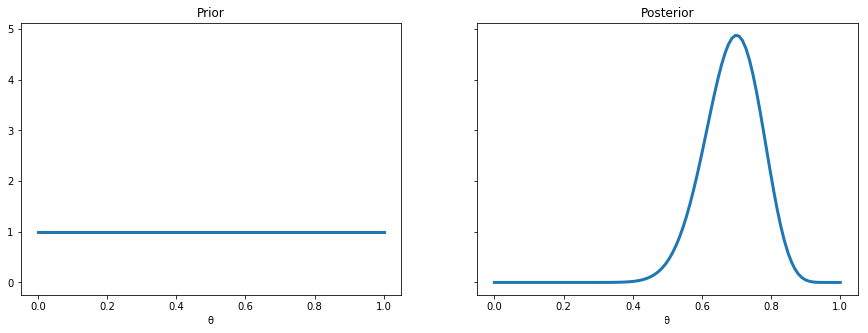

In [3]:
plt.rcParams['figure.figsize'] = 15, 5

xs = np.linspace(0, 1, 100)
p = 0.7

num_flips = 30
coin_flips = np.random.random(size=num_flips) < p
num_heads = np.sum(coin_flips)

print('True probability of heads: {}'.format(p))
print('Flips observed: ', coin_flips.astype(np.int32))
print('Heads observed: {}'.format(num_heads))

prior = calculate_posterior(xs, 0, 0)
posterior = calculate_posterior(xs, num_flips, num_heads)

fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].set_title('Prior')
axes[0].plot(xs, prior, lw=3)
axes[1].set_title('Posterior')
axes[1].plot(xs, posterior, lw=3)
axes[0].set_xlabel('θ')
axes[1].set_xlabel('θ');

# Non-analytic, Monte Carlo Approach: Rejection Sampling
# (Samples $\neq$ data!)

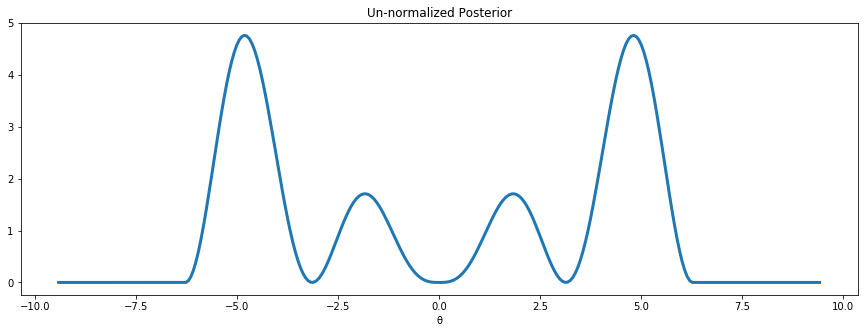

In [4]:
xs = np.linspace(-3*np.pi, 3*np.pi, 300)

def unnormalized_posterior(x):
    return np.abs(x) * np.sin(x)**2 * (np.abs(x) < 2*np.pi)

plt.plot(xs, unnormalized_posterior(xs), lw=3)
plt.title('Un-normalized Posterior')
plt.xlabel('θ');

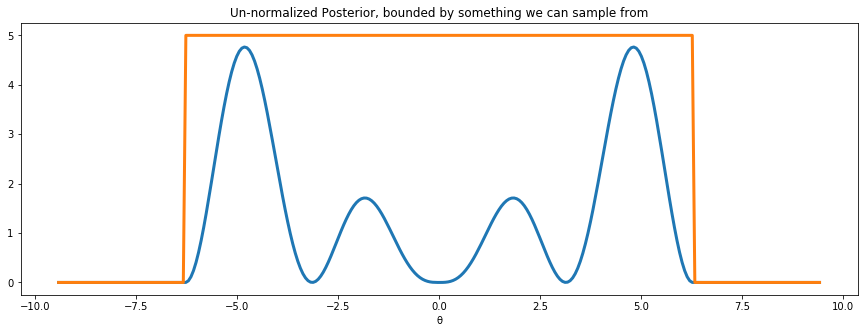

In [5]:
plt.plot(xs, unnormalized_posterior(xs), lw=3)
plt.plot(xs, 5 * (np.abs(xs) < 2*np.pi), lw=3)
plt.title('Un-normalized Posterior, bounded by something we can sample from')
plt.xlabel('θ');

$x \sim \text{Uniform}(-2\pi, 2\pi)$

$y \sim \text{Uniform}(0, 5)$

If $y < f(x)$, keep the sample. Otherwise, reject.

Efficiency: 2000 uniform distribution samples + 1000 evaluations of f(θ) for 316/1000 samples accepted


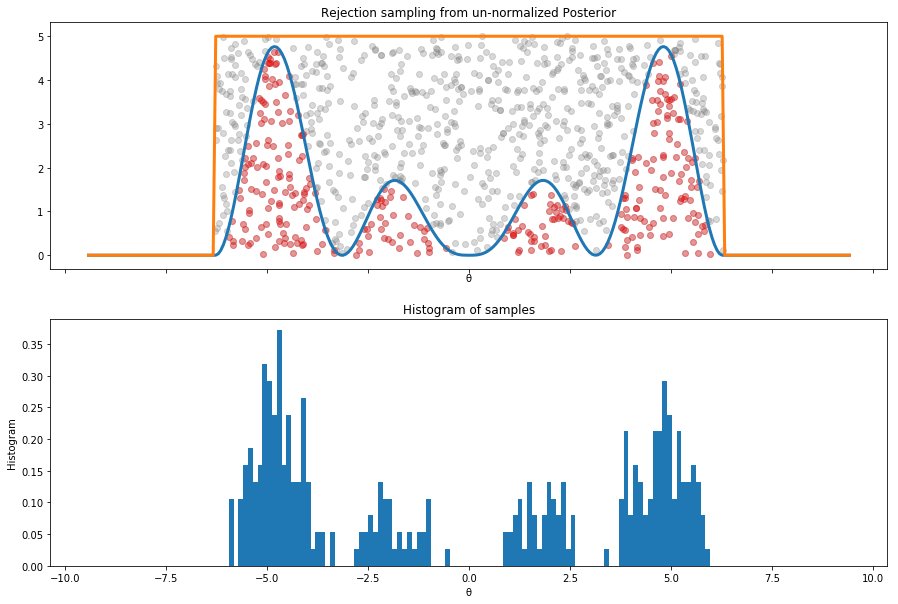

In [34]:
num_samples = 1000
x_samples = np.random.uniform(-2*np.pi, 2*np.pi, size=num_samples)
y_samples = np.random.uniform(0, 5, size=num_samples)

idx_of_samples_to_keep = y_samples < unnormalized_posterior(x_samples)
posterior_samples = x_samples[idx_of_samples_to_keep]
posterior_ys = y_samples[idx_of_samples_to_keep]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
axes[0].plot(xs, unnormalized_posterior(xs), lw=3);
axes[0].plot(xs, 5 * (np.abs(xs) < 2*np.pi), lw=3);
axes[0].scatter(x_samples, y_samples, c='gray', alpha=0.3);
axes[0].scatter(posterior_samples, posterior_ys, c='red', alpha=0.3);
axes[0].set_title('Rejection sampling from un-normalized Posterior')
axes[1].hist(posterior_samples, bins=100, density=True);
axes[1].set_title('Histogram of samples')
axes[0].set_xlabel('θ')
axes[1].set_xlabel('θ')
axes[1].set_ylabel('Histogram')

print('Efficiency: {0} uniform distribution samples + {1} evaluations of f(θ) for {2}/{1} samples accepted'.format(2*num_samples, num_samples, posterior_samples.size))

# In High Dimensions, Rejection Sampling Almost Always *Rejects*

# Solution: MCMC (Markov Chain Monte Carlo)

<img src="./images/posterior.svg" width="850" />

<img src="./images/kruschke.jpg" width="850" />


## Frameworks/Languages (each of these implements MCMC sampling and variational inference):
- Stan (with Python, R interfaces)
- PyMC3
- Edward (built on TensorFlow)

## Example 1: Coin Bias Inference

95% highest density interval: (0.5, 0.69) 	true value: 0.6


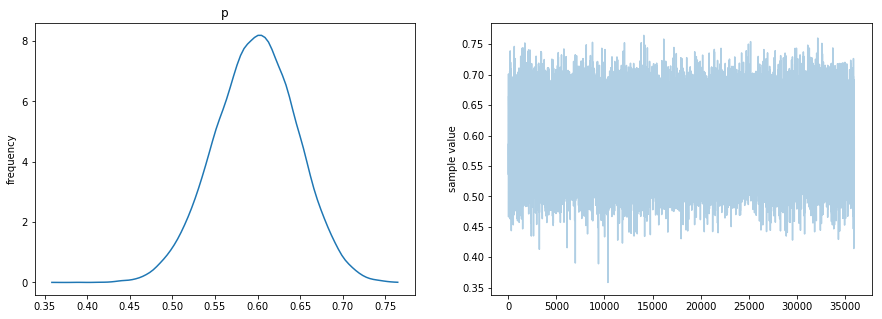

In [16]:
import pystan
import pickle
import os
import os.path


coin_code = """
data {
    int<lower=0> n;   // number of coin tosses
    int<lower=0> y;   // number of heads
}
parameters {
    real<lower=0, upper=1> p;
}
model {
    p ~ beta(1, 1);
    y ~ binomial(n, p);
}
"""

coin_data = {'n': 100,
             'y': 60}

# Compile or unpickle the model
os.makedirs('models', exist_ok=True)
model_path = 'models/coin_model.pkl'
if os.path.isfile(model_path):
    coin_model = pickle.load(open(model_path, 'rb'))
else:
    coin_model = pystan.StanModel(model_code=coin_code)
    with open(model_path, 'wb') as f:
        pickle.dump(coin_model, f)


# Do MCMC sampling from posterior
fit = coin_model.sampling(data=coin_data,
                          iter=10000,
                          warmup=1000,
                          thin=1,
                          chains=4)
fit.plot();

def hdi(samples, cred_mass = 0.95):
    sorted_samples = np.sort(samples)
    ci_idx_inc = int(np.floor(cred_mass*len(sorted_samples)))
    n_cis = len(sorted_samples) - ci_idx_inc
    ci_width = sorted_samples[ci_idx_inc:] - sorted_samples[:n_cis]

    min_idx = np.argmin(ci_width)
    hdi_min = sorted_samples[min_idx]
    hdi_max = sorted_samples[min_idx + ci_idx_inc]
    return int(100*hdi_min)/100, int(100*hdi_max)/100

print('95% highest density interval:', hdi(fit['p']), '\ttrue value: 0.6');

## Example 2: Alternative to Hypothesis Testing

/home/andrew/.virtualenvs/default/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


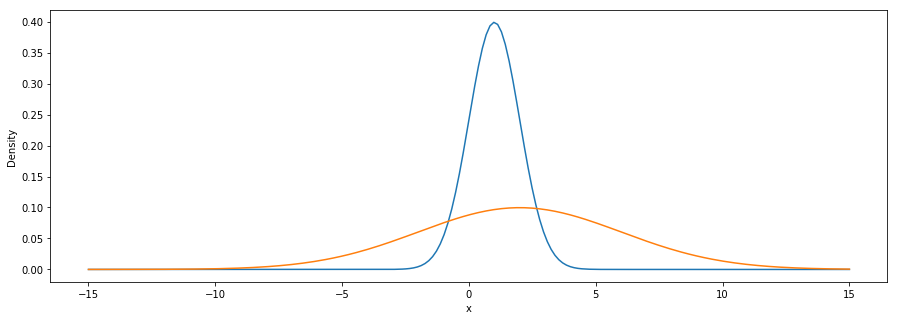

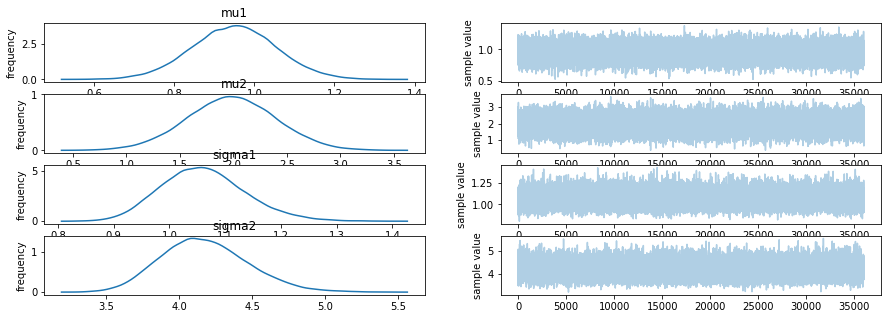

In [28]:
mean_diff_code = """
data {
    int<lower=0> N;  // number of samples from each distribution
    real x1[N];      // samples from distribution 1
    real x2[N];      // samples from distribution 2
}
parameters {
    real mu1;   // mean of distribution 1
    real mu2;   // mean of distribution 2
    real<lower=0> sigma1;   // std of distribution 1
    real<lower=0> sigma2;   // std of distribution 2
}
model {
    mu1 ~ normal(0, 1000);
    mu2 ~ normal(0, 1000);
    sigma1 ~ uniform(0.0001, 1000);
    sigma2 ~ uniform(0.0001, 1000);
    x1 ~ normal(mu1, sigma1);
    x2 ~ normal(mu2, sigma2);
}
"""

# Generate data
N = 100
true_mu1 = 1
true_mu2 = 2
true_sigma1 = 1
true_sigma2 = 4
xs1 = np.random.normal(loc=true_mu1, scale=true_sigma1, size=N)
xs2 = np.random.normal(loc=true_mu2, scale=true_sigma2, size=N)

mean_diff_data = {'N': N,
                  'x1': xs1,
                  'x2': xs2}

x_range = np.linspace(-15, 15, 200)
plt.plot(x_range, stats.norm(true_mu1, true_sigma1).pdf(x_range))
plt.plot(x_range, stats.norm(true_mu2, true_sigma2).pdf(x_range))
plt.xlabel('x')
plt.ylabel('Density')


# Compile or unpickle the model
model_path = 'models/mean_diff_model.pkl'
if os.path.isfile(model_path):
    mean_diff_model = pickle.load(open(model_path, 'rb'))
else:
    mean_diff_model = pystan.StanModel(model_code=mean_diff_code)
    with open(model_path, 'wb') as f:
        pickle.dump(mean_diff_model, f)


# Do MCMC sampling from posterior
fit = mean_diff_model.sampling(data=mean_diff_data,
                               iter=10000,
                               warmup=1000,
                               thin=1,
                               chains=4)
fit.plot();

In [29]:
# HDI
print('95% Highest Density Intervals:')
print('mu1:', hdi(fit['mu1']), '\ttrue value: {}'.format(true_mu1))
print('mu2:', hdi(fit['mu2']), '\ttrue value: {}'.format(true_mu2))
print('sigma1:', hdi(fit['sigma1']), '\ttrue value: {}'.format(true_sigma1))
print('simga2:', hdi(fit['sigma2']), '\ttrue value: {}'.format(true_sigma2))

print('\nProbability that mu1 < mu2: {:.3f}'.format(np.mean(fit['mu1'] < fit['mu2'])))

95% Highest Density Intervals:
mu1: (0.73, 1.15) 	true value: 1
mu2: (1.16, 2.8) 	true value: 2
sigma1: (0.91, 1.21) 	true value: 1
simga2: (3.62, 4.77) 	true value: 4

Probability that mu1 < mu2: 0.991


## Example 3: Linear Regression

/home/andrew/.virtualenvs/default/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


95% Highest Density Intervals:
m: (1.31, 2.38) 	true value: 2
b: (-2.71, 2.47) 	true value: 1


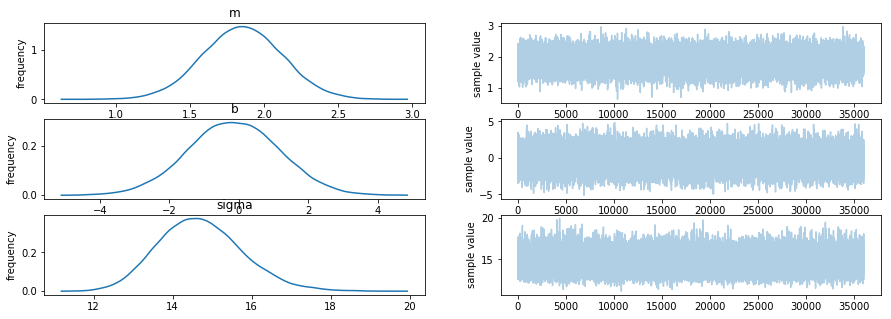

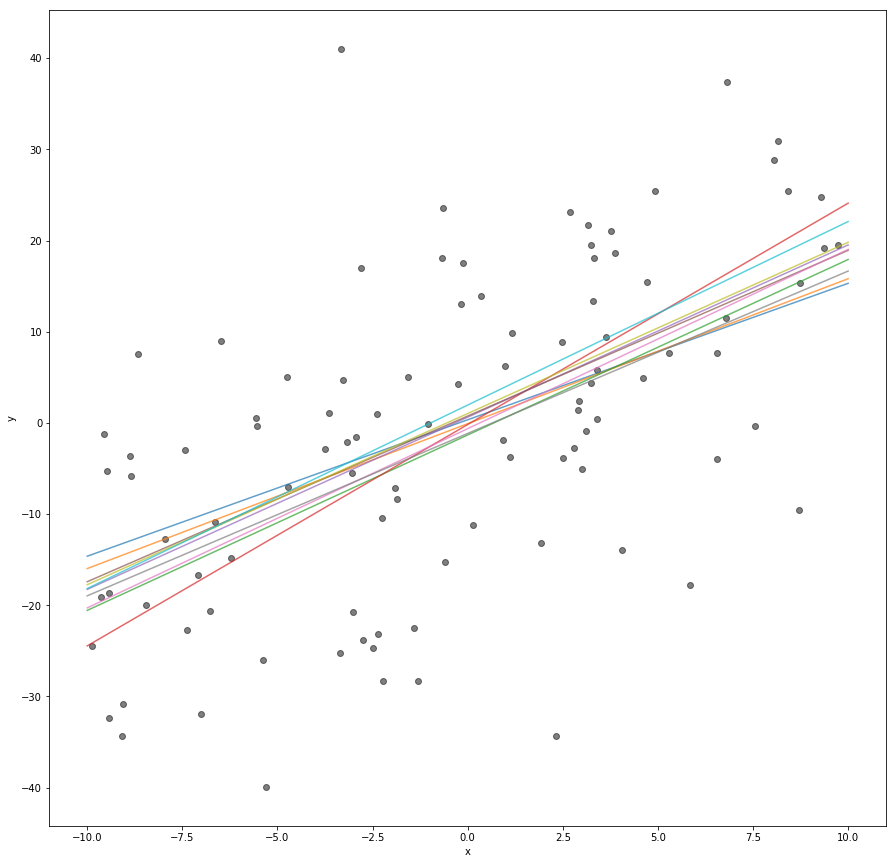

In [40]:
regression_code = """
data {
    int<lower=0> N; // number of samples
    real x[N];      // independent variable
    real y[N];      // dependent variable
}
parameters {
    real m;     // slope
    real b;     // intercept
    real sigma; // Gaussian noise standard deviation
}
transformed parameters {
    real mu[N];
    for (i in 1:N) {
        mu[i] = m*x[i] + b;
    }
}
model {
    m ~ uniform(-3, 5);
    b ~ normal(0, 3);
    sigma ~ uniform(0, 20);
    y ~ normal(mu, sigma);
}
"""

# Generate data
N = 100
x_vals = np.random.uniform(-10, 10, size=N)
true_m = 2
true_b = 1
true_sigma = 14
ys = np.random.normal(loc=true_m*x_vals + true_b, scale=true_sigma)

regression_data = {'n': N,
                   'x': x_vals,
                   'y': ys}


# Compile or unpickle the model
model_path = 'models/regression_model.pkl'
if os.path.isfile(model_path):
    regression_model = pickle.load(open(model_path, 'rb'))
else:
    regression_model = pystan.StanModel(model_code=regression_code)
    with open(model_path, 'wb') as f:
        pickle.dump(regression_model, f)

# Do MCMC sampling from posterior
fit = regression_model.sampling(data=regression_data,
                     iter=10000,
                     warmup=1000,
                     thin=1,
                     chains=4)
fit.plot(['m','b','sigma']);

# HDI
print('95% Highest Density Intervals:')
print('m:', hdi(fit['m']), '\ttrue value: {}'.format(true_m))
print('b:', hdi(fit['b']), '\ttrue value: {}'.format(true_b))

# Plot some samples from the posterior
indices = np.random.choice(N, replace=False, size=10)
m_samples = fit['m'][indices]
b_samples = fit['b'][indices]
x_range = np.linspace(-10, 10, 100)
y_samples = [m*x_range + b for m, b in zip(m_samples, b_samples)]
f, ax = plt.subplots(figsize=(15,15))
for y in y_samples:
    ax.plot(x_range, y, alpha=0.7)
ax.scatter(x_vals, ys, c='k', alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y');